In [1]:
# Import methods

%run Methods.ipynb

color_map = 'flare'

In [2]:
####STD
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\2024\24LSB01\STD'
setup_files(path)
area = np.pi
thickness = 90
sample = 'STD'
std = cc(path, area, thickness, sample)

c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1241: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1241: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Loca

10


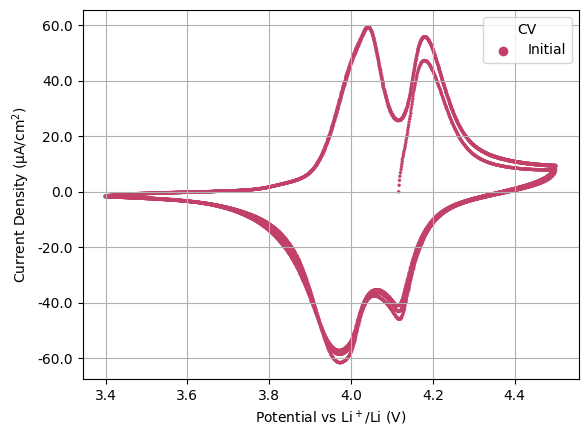

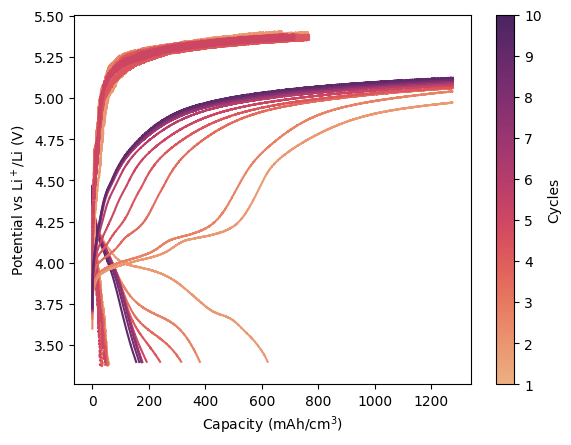

In [3]:
#### PLOT STD
cv_plot(std, color_map, 100)
cc_plot(std, color_map, 100)

In [4]:
#STD_02 Second sample for Xinhua after breaking 1st at 5V
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\2024\24LSB01\STD_02'
setup_files(path)
area = np.pi
thickness = 90
sample = 'STD_02'
results = cc(path, area, thickness, sample)

c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1241: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1241: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Loca

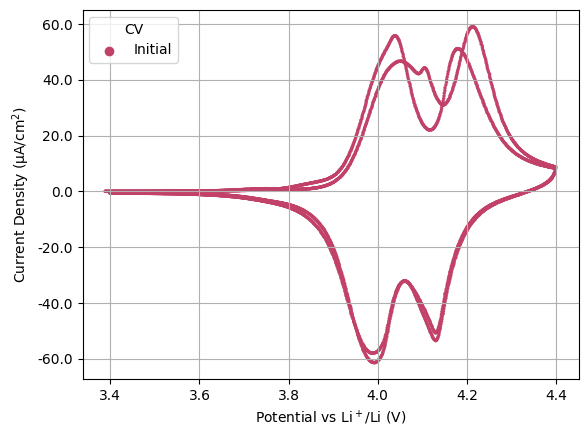

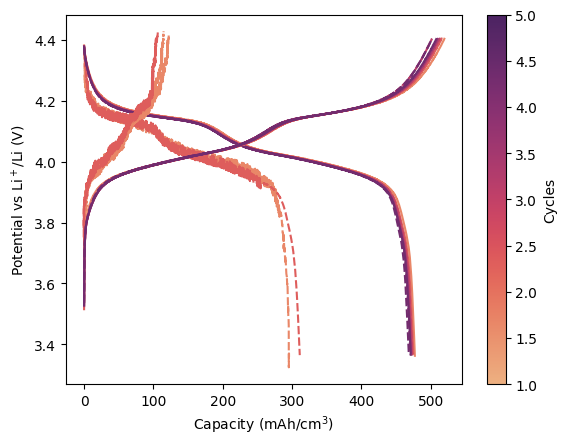

In [5]:
### PLOT STD_02

cv_plot(results, color_map, 100)
cc_plot(results, color_map, 100)

In [5]:
# STD_02_2 New sample after blowing up to 5V Second run
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\2024\24LSB01\STD_02_2'
setup_files(path)
area = np.pi
thickness = 90
sample = 'LMO 1C'
std02_1C = cc(path, area, thickness, sample)

c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1241: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1241: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Loca

5


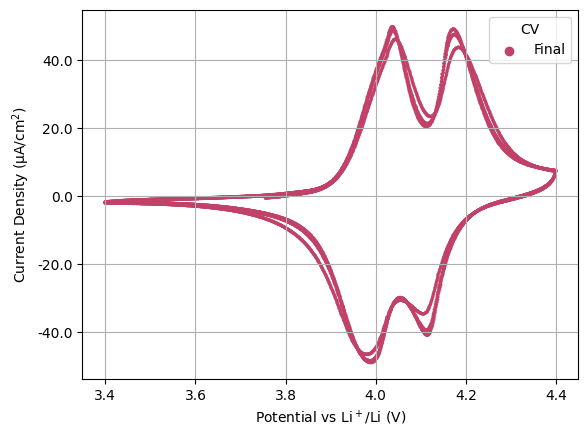

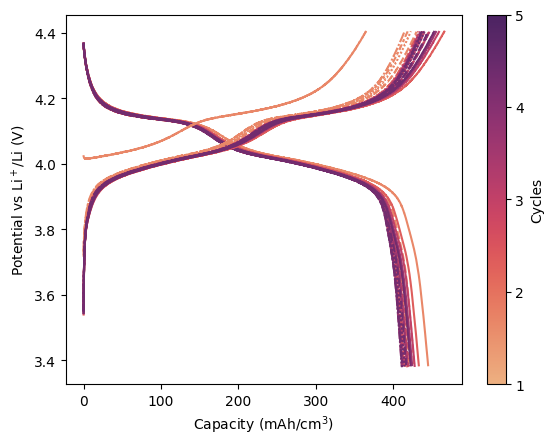

In [6]:
###PLOT STD_02_2

cv_plot(std02_1C, color_map, 100)
cc_plot(std02_1C, color_map, 100)
# dq_dv_plot(std02_1C, color_map, 100)
# plt.ylim(-100, 400)

In [7]:
# STD_02_2C
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\2024\24LSB01\STD02_2C'
setup_files(path)
area = np.pi
thickness = 90
sample = 'LMO 2C'
std02_2c = cc(path, area, thickness, sample)

c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1241: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1248: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -

5


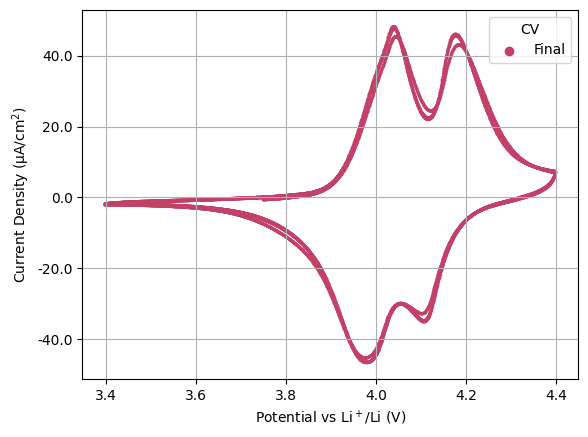

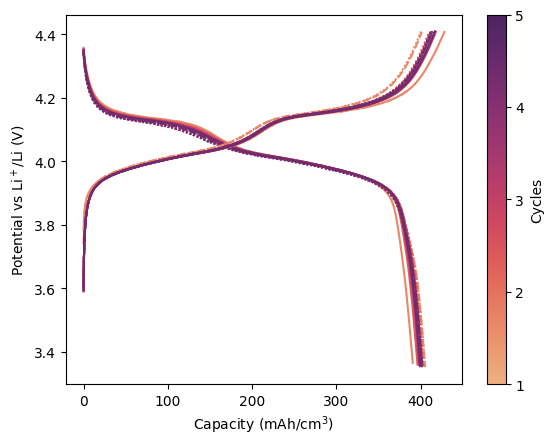

In [8]:
##### PLOT STD02 2C
cv_plot(std02_2c, color_map, 100)
cc_plot(std02_2c, color_map, 100)
# dq_dv_plot(std02_2c, color_map, 100)
# plt.ylim(-10, 250)

In [9]:
# STD_02_5C
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\2024\24LSB01\STD_02_5C'
setup_files(path)
area = np.pi
thickness = 90
sample = 'LMO 5C'
std02_5c = cc(path, area, thickness, sample)

5


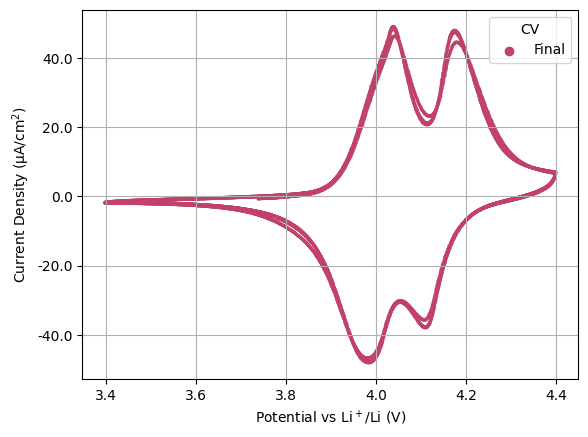

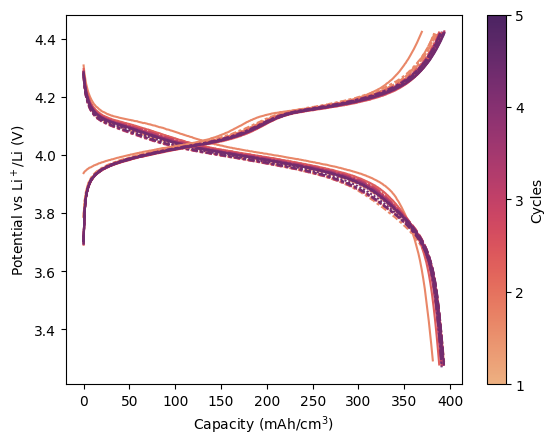

In [10]:
#### STD_02_5C Plot
cv_plot(std02_5c, color_map, 100)
cc_plot(std02_5c, color_map, 100)
# dq_dv_plot(std02_5c, color_map, 100)
# plt.ylim(-10, 250)

In [11]:
# New LMO cv low potentials 1.5V
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\2024\24LSB01\STD_CV'
setup_files(path)
area = np.pi
thickness = 90
sample = 'LMO lp 1.5V'
std02_lp = cc(path, area, thickness, sample)

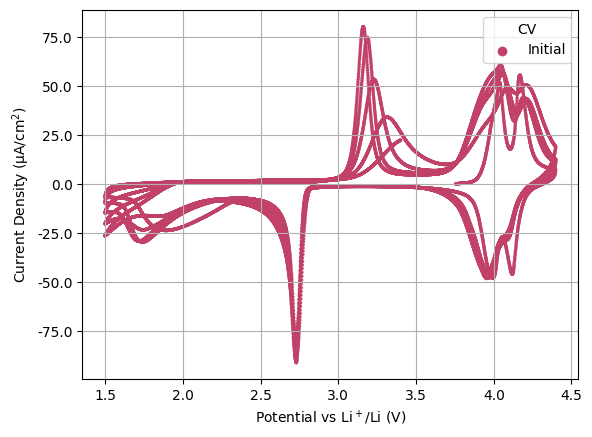

In [16]:
# ##### LMO lp PLOT
cv_plot(std02_lp, color_map, 100)
# cv_scan_plot(std02_lp, color_map, 100)
# cc_plot(std02_lp, color_map, 100) ###ONLY CV in FILEs
# d = std02_lp[0]
# for i in d['Scan'].unique():
#     d_filt = d[d['Scan'] == i]
#     fig, ax = plt.subplots(dpi = 100)
#     sns.scatterplot(data = d_filt, x = col_cv[0], y = strings[0], edgecolor = None, s = 3, label = f'Scan {i}')
#     ax.yaxis.set_major_formatter(formatter_1e6)
#     plt.ylabel(strings[1])
#     plt.grid()
#     plt.ylim(-0.0001, 0.00009)



In [17]:
# New LMO cycling scanning at low potentials
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\2024\24LSB01\STD_CV_afterlowpot'
setup_files(path)
area = np.pi
thickness = 90
sample = 'LMO after 1.5V'
std02_lowp = cc(path, area, thickness, sample)

c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1241: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1241: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Loca

2


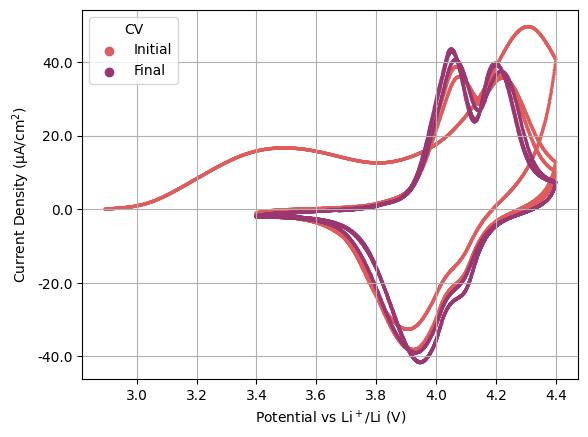

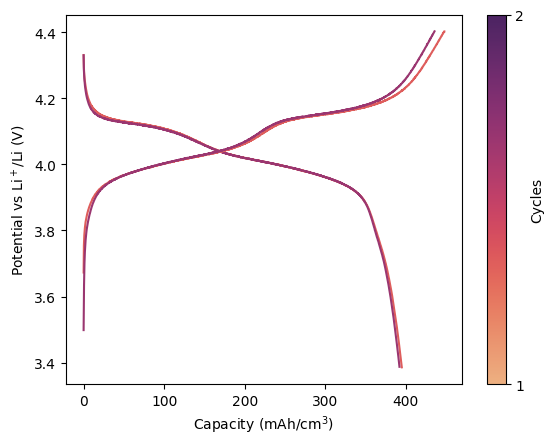

In [18]:
# # LMO cycling afterlow pot PLOTS
# color_map = 'flare'
cv_plot(std02_lowp, color_map, 100)

cc_plot(std02_lowp, color_map, 100)
# plt.grid()
# dq_dv_plot(std02_lowp, color_map, 100)
# plt.ylim(-10, 200)

In [19]:
#### LMO cycled 1V

path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\2024\24LSB01\STD_to1V'
setup_files(path)
area = np.pi
thickness = 90
sample = 'LMO cycled 1V'
std02_1v = cc(path, area, thickness, sample)

c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1241: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1241: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Loca

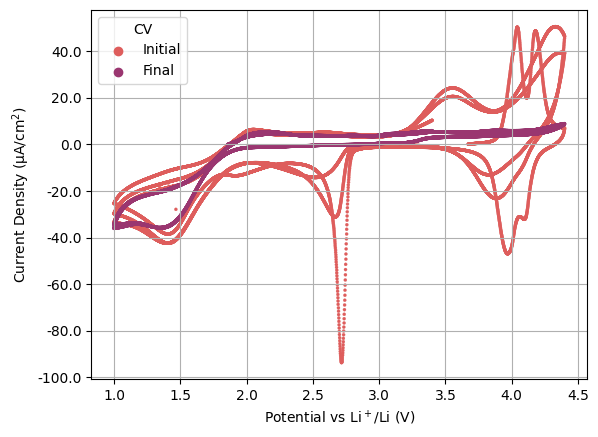

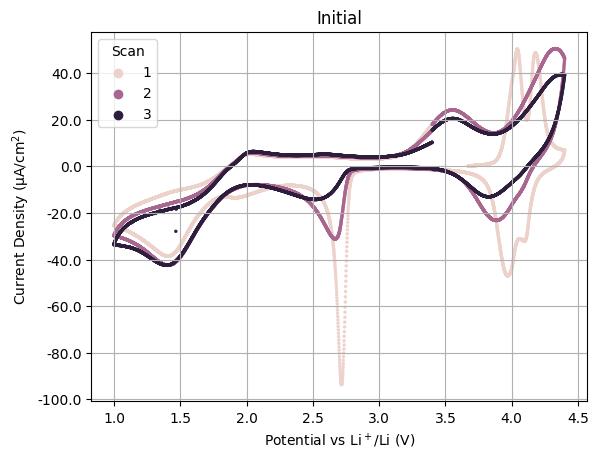

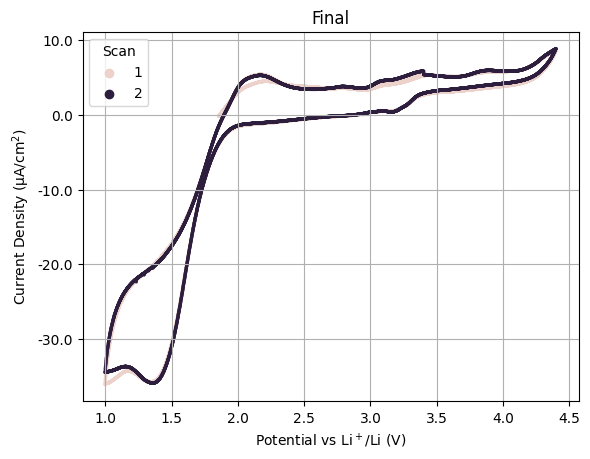

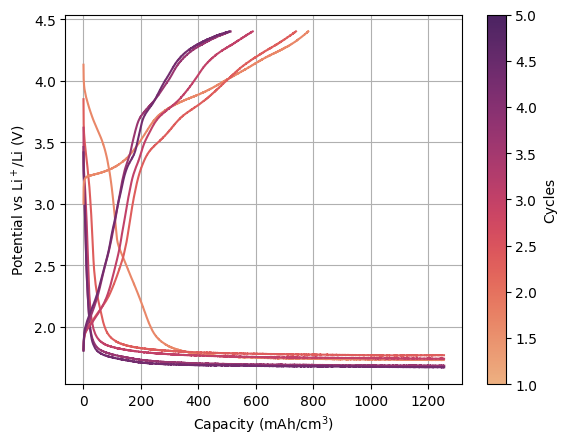

In [17]:
### PLOTS LMO cycled 1V 
color_map = 'flare'
dpi = 100
cv_plot(std02_1v, color_map, dpi)
cv_scan_plot(std02_1v, dpi)
cc_plot(std02_1v, color_map, dpi)
plt.grid()
# dq_dv_plot(std02_1v, color_map, dpi)
# plt.ylim(3., 4.5)
# plt.xlim(0, 500)

<AxesSubplot: xlabel='WE(1).Potential (V)', ylabel='dQ/dV'>

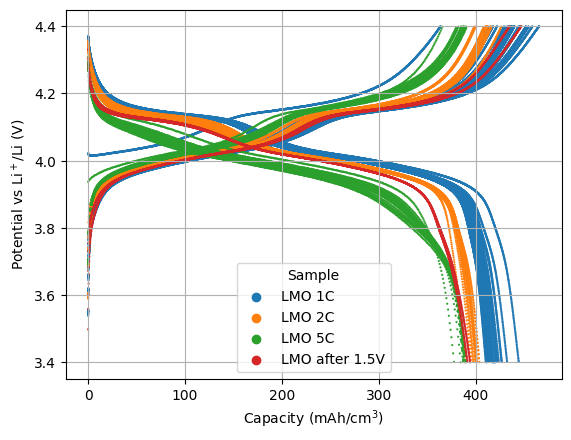

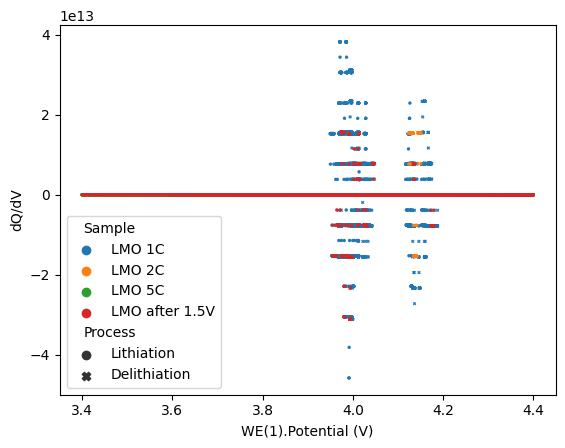

In [20]:
###### Compile 1C, 2C and 5C
results = [std02_1C, std02_2c, std02_5c, std02_lowp]
for i in results:
    i[1] = i[1][i[1]['WE(1).Potential (V)'] > 3.4]
    i[2] = i[2][i[2]['WE(1).Potential (V)'] < 4.4]

results_df = pd.DataFrame()
for i in results:
    results_df = pd.concat([results_df, i[1], i[2]], ignore_index = True)
    
fig, ax = plt.subplots(dpi = 100)
sns.scatterplot(data = results_df, x = 'Capacity (mAh/cm$^3$)', y = 'WE(1).Potential (V)', hue = 'Sample', edgecolor = None, s = 2)
ax.grid()
ax.set_ylabel(col_cv[0])


fig, ax = plt.subplots(dpi = 100)
sns.scatterplot(data = results_df, x = 'WE(1).Potential (V)', y = 'dQ/dV', hue = 'Sample', style = 'Process', edgecolor = None, s = 5)
# plt.ylim(-10, 400)
